# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- Extracting Data
    - Python imports
    - Fetch COVID-19 data from Our World in Data
    - Fetch Canadian specific data from www.canada.ca
- Filtering and Cleaning
    - Extract world record
    - Filtering for the latest data
    - Preparing population data
        -  Missing population data
    - Appending inferred information
    - Preparing Canadian specific data
- Analysis
    - World record
        - Plots
        - Table
    - Top 5: total cases per capita and deaths per total
        - Plots
        - Tables
    - Comparison between select countries
    - Highest number of total cases and deaths
        - Plots
        - Tables
    - Canadian provinces and territories
        - Canadian provinces and territories
        - Cases and Deaths
            - Plots
            - Tables
                - Total
                - Sorted by confirmed cases
        - Per Capita
            - Plots
            - Tables
                - Sorted by confirmed cases per capita
                - Population

## Extracting coronavirus and country data

### Python Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

from scrape_covid19_data import DataScraper

### Fetch COVID-19 data from Our World in Data

In [2]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [3]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Get Canadian specific data from www.canada.ca

In [4]:
r = requests.get('https://health-infobase.canada.ca/src/data/summary_current.csv')

In [5]:
with open('summary_current.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Load data 

In [6]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 
canadian_data = pd.read_csv('summary_current.csv')

In [7]:
rdata.tail(n = 2)

,date,location,new_cases,new_deaths,total_cases,total_deaths
7603,2020-03-28,Zimbabwe,2,0,5,1
7604,2020-03-29,Zimbabwe,2,0,7,1


In [8]:
rpopulation_data.head(n = 2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN


In [9]:
canadian_population_dict = {'Population':[14711827, 8537674, 5110917, 4413146, 1377517, 1181666, 977457, 779993, 521365, 158158, 44904, 39097, 41078], 
                            'Location':['Ontario', 'Quebec', 'British Columbia', 'Alberta','Manitoba','Saskatchewan',
                                        'Nova Scotia', 'New Brunswick', 'Newfoundland and Labrador','Prince Edward Island', 'Northwest Territories','Nunavut','Yukon']}

canadian_population = pd.DataFrame.from_dict(canadian_population_dict)

## Filtering and cleaning data 

In [10]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object
Columns with NaN Index([], dtype='object')


In [11]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object

In [12]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [13]:
latest = pdata['date'].max()
latest

'2020-03-29'

In [14]:
canadian_data['date'] = pd.to_datetime(canadian_data['date'], infer_datetime_format='%d-%m-%Y')

In [15]:
latest_canadian = canadian_data['date'].max()
canadian_data.tail(n = 2)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtoday
285,99,Repatriated travellers,Voyageurs rapatriés,2020-03-28,13,0,0,13,NaN
286,1,Canada,Canada,2020-03-28,4743,14,55,4757,NaN


### Extract world record

In [16]:
world_record = rdata[rdata['location'] == 'World']

In [17]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

### Filtering for the latest data

In [18]:
data = pdata[pdata['date'] == latest]
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [19]:
data = data[data.index != 'World']

In [20]:
max_total_cases = data['total_cases'].max()

In [21]:
canadian_data = canadian_data[canadian_data['date'] == latest_canadian]
canadian_data = canadian_data.drop(columns = ['pruid', 'date','prnameFR'])

### Preparing population data

In [22]:
population = rpopulation_data.filter(['Country Name', '2018'])

In [23]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')
population.head(n=1)

,2018
location,
Aruba,105845.0


#### Missing population data

In [24]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths
location,,,,
Anguilla,0,0,2,0
Guernsey,3,0,39,0
Jersey,9,0,61,1
Montserrat,0,0,5,0
Palestine,6,0,97,1
Saint Kitts and Nevis,0,0,2,0
Taiwan,16,0,283,2
Vatican,1,0,6,0


### Appending inferred information 

In [25]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018']))
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018']))
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Afghanistan,15,1,106,3,2.851579e-06,8.070507e-08,0.0283
Albania,11,1,197,10,6.872790e-05,3.488726e-06,0.0508
Algeria,104,5,409,26,9.685418e-06,6.156990e-07,0.0636
Andorra,41,1,308,4,3.999688e-03,5.194400e-05,0.0130
Angola,0,0,4,0,1.298290e-07,0.000000e+00,0.0000


### Preparing Canadian specific data

In [26]:
canadian_data = canadian_data.rename(columns = {'numconf': 'Confirmed Cases', 
                                                'numprob':'Probable Cases',
                                                'numtotal':'Total',
                                                'numtoday':'Today',
                                                'numdeaths': 'Deaths',
                                                'prname':'Location'})

In [27]:
canadian_data.set_index('Location', inplace = True)
canadian_population.set_index('Location', inplace = True)

In [28]:
canadian_data_total = canadian_data[canadian_data.index == 'Canada']

In [29]:
canadian_data = canadian_data[canadian_data.index.isin(canadian_population.index) == True]
canadian_population = canadian_population[canadian_population.index.isin(canadian_data.index) == True]

In [30]:
canadian_data['Deaths per Confirmed Cases'] = (canadian_data['Deaths'].div(canadian_data['Confirmed Cases']))

In [31]:
canadian_data = canadian_data.assign(Confirmed_Cases_Per_Capita = canadian_data['Confirmed Cases'].div(canadian_population['Population']))
canadian_data = canadian_data.assign(Deaths_Per_Capita = canadian_data['Deaths'].div(canadian_population['Population']))

In [32]:
canadian_data.rename(columns = {'Confirmed_Cases_Per_Capita':'Confirmed Cases Per Capita', 
                                'Deaths_Per_Capita':'Deaths Per Capita'}, inplace = True)

## Analysis

### World record

#### Plots

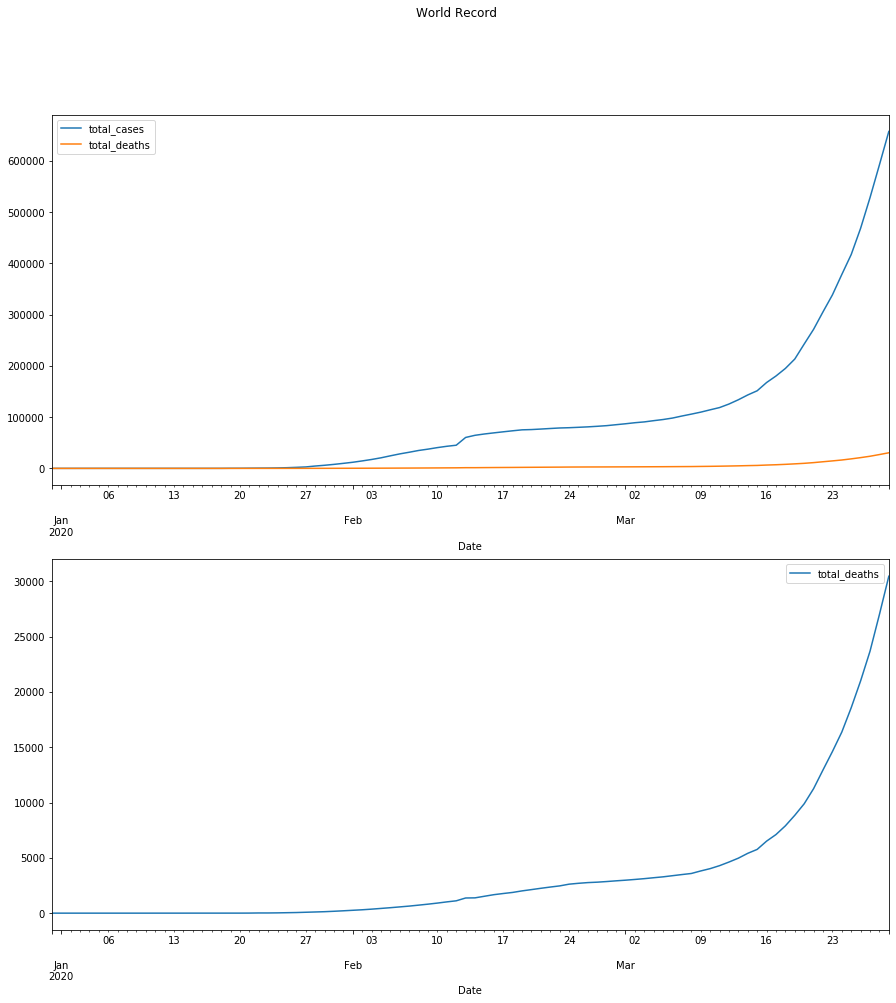

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))

fig.suptitle('World Record')

world_record.index.name = 'Date'

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', ax = ax2)

plt.savefig('world.png', bbox_inches = 'tight')

#### Table

In [34]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-03-29,World,65169,3461,657140,30451


### Top 5: total cases per capita and deaths per total

In [35]:
highest_total_cases_pc = data.nlargest(5, 'total_cases_per_capita')

In [36]:
highest_total_cases_pc = highest_total_cases_pc.merge(population, on = 'location')

In [37]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases = deaths_per_cases.merge(population, on = 'location')

In [38]:
total_cases_for_table = highest_total_cases_pc.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
total_cases_for_table = total_cases_for_table.reset_index()
total_cases_for_table = total_cases_for_table.rename(columns = {'2018':'population'})

In [39]:
deathsratio_for_table = deaths_per_cases.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
deathsratio_for_table = deathsratio_for_table.reset_index()
deathsratio_for_table = deathsratio_for_table.rename(columns = {'2018':'population'})

#### Plots

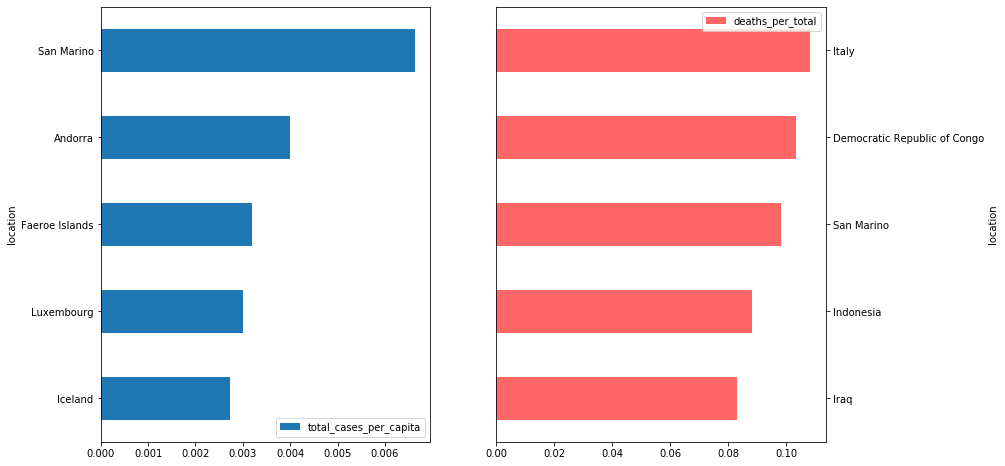

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
highest_total_cases_pc.sort_values(by = 'total_cases_per_capita', ascending = True).plot(kind='barh',y = 'total_cases_per_capita', ax = ax1,
                            ylim = (0, data['total_cases_per_capita'].max()+ 0.0005))

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
deaths_per_cases.sort_values(by = 'deaths_per_total', ascending = True).plot.barh(y = 'deaths_per_total', 
                                                      color ='red', ax = ax2,
                                                      alpha = 0.6)
plt.savefig('total_cases_per_capita_and_deaths_per_total.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases per capita

In [41]:
total_cases_for_table

,location,new_cases,total_cases,total_cases_per_capita,population
0,San Marino,1,224,0.006630,33785.0
1,Andorra,41,308,0.004000,77006.0
2,Faeroe Islands,11,155,0.003196,48497.0
3,Luxembourg,226,1831,0.003013,607728.0
4,Iceland,73,963,0.002724,353574.0


##### Highest deaths to total cases

In [42]:
deathsratio_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,Italy,92472,10023,0.1084,60431283.0
1,Democratic Republic of Congo,58,6,0.1034,84068091.0
2,San Marino,224,22,0.0982,33785.0
3,Indonesia,1155,102,0.0883,267663435.0
4,Iraq,506,42,0.0830,38433600.0


### Comparison between select countries

In [43]:
filter_countries = ['Canada','United States', 'Pakistan', 'China', 'Italy']

In [44]:
earliest = '2020-03-01'
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]
country_subset = country_subset.drop(columns = ['date'])
country_subset = country_subset.set_index('date_fm')
country_subset.index.name = 'Date'

In [45]:
percapita = pd.DataFrame(country_subset['location'])
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018']))

In [46]:
percapita_total = pd.DataFrame(country_subset['location'])
percapita_total['total_cases_per_capita'] =  country_subset['total_cases'].div(country_subset['location'].map(population['2018']))

#### Plots

##### By new cases

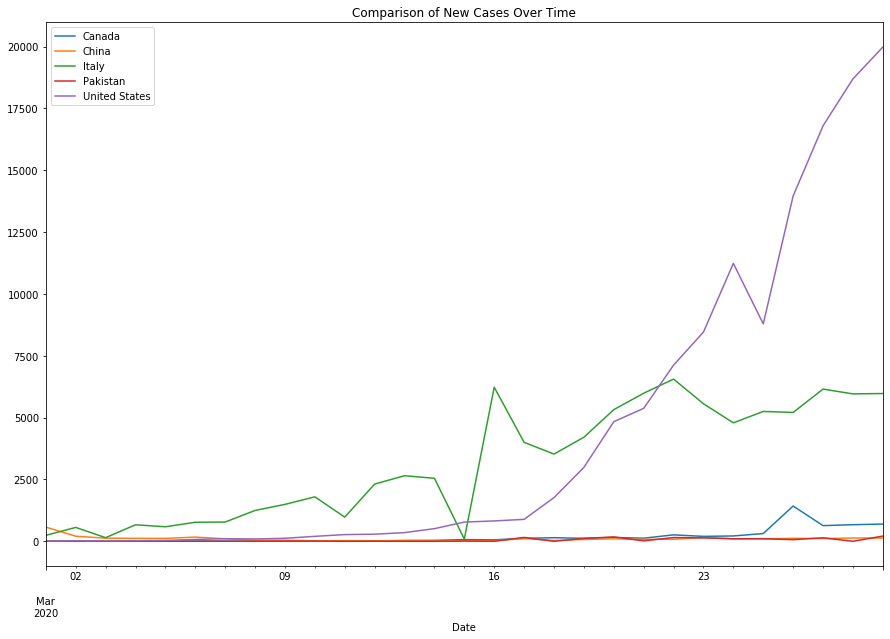

In [47]:
_, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Comparison of New Cases Over Time')

for name, group in country_subset.groupby('location'):
    group.plot(kind ='line', y = 'new_cases', ax = ax, label = name)

plt.savefig('select_countries_new_cases.png', bbox_inches = 'tight')

##### New cases per capita

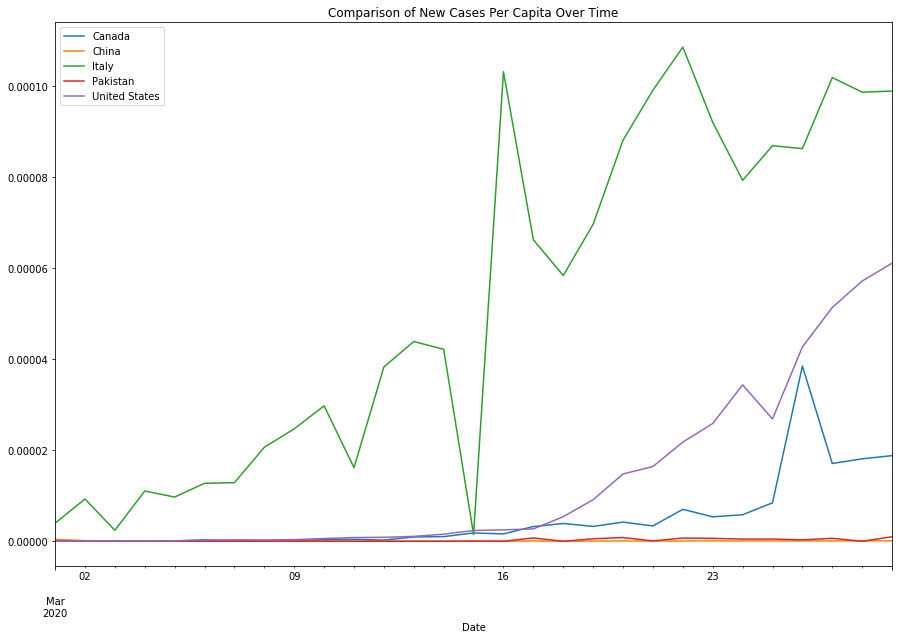

In [48]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Cases Per Capita Over Time')

for name, group in percapita.groupby('location'):
    group.plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_cases_per_capita.png', bbox_inches = 'tight')

##### Total cases per capita

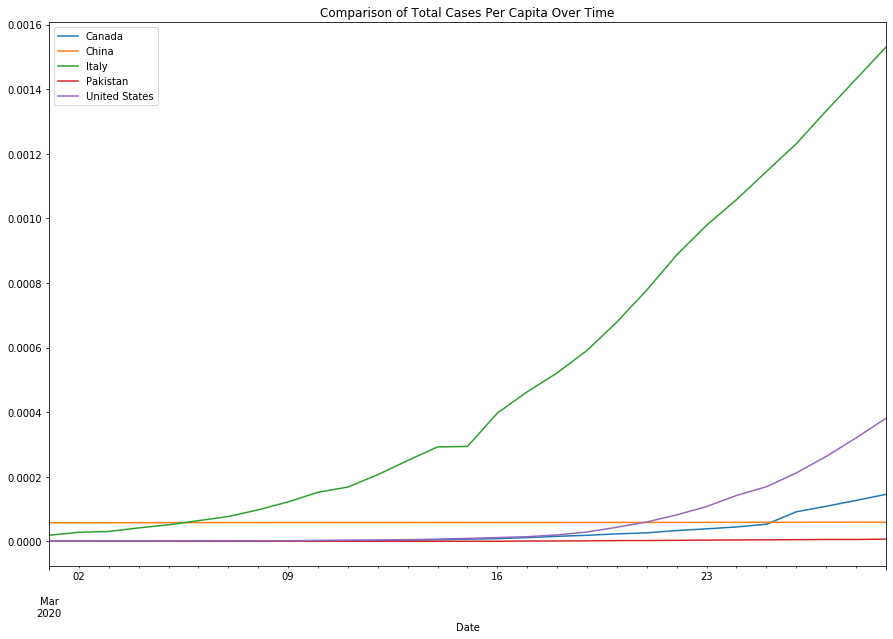

In [49]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of Total Cases Per Capita Over Time')

for name, group in percapita_total.groupby('location'):
    group.plot(kind ='line', y = 'total_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_total_cases_per_capita.png', bbox_inches = 'tight')

In [84]:
country_subset_latest = country_subset[country_subset.index == latest]
country_subset_latest

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-03-29,Canada,697,7,5386,60
2020-03-29,China,129,5,82342,3306
2020-03-29,Italy,5974,887,92472,10023
2020-03-29,Pakistan,211,2,1408,11
2020-03-29,United States,19979,484,124665,2191


### Highest number of total cases and deaths

In [51]:
highest_total_cases = data.nlargest(5, 'total_cases')
highest_deaths = data.nlargest(5, 'total_deaths')

#### Plots

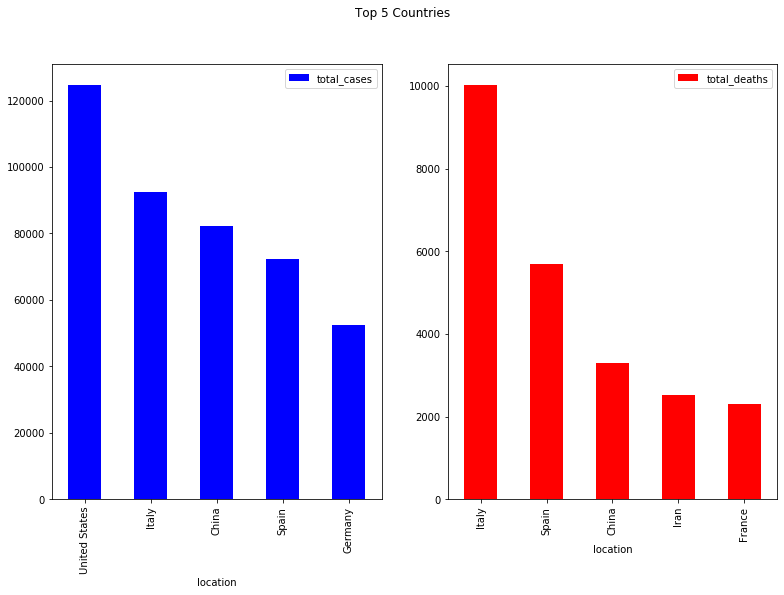

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
fig.suptitle('Top 5 Countries')

highest_total_cases.plot(kind = 'bar', y = 'total_cases', color = ['blue'], ax = ax1)
highest_deaths.plot(kind = 'bar', y = 'total_deaths', color = ['red'], ax = ax2)
plt.savefig('highest_total_cases_and_deaths.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases

In [53]:
highest_total_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
United States,19979,484,124665,2191,0.000381,0.000007,0.0176
Italy,5974,887,92472,10023,0.001530,0.000166,0.1084
China,129,5,82342,3306,0.000059,0.000002,0.0401
Spain,8189,832,72248,5690,0.001546,0.000122,0.0788
Germany,3965,64,52547,389,0.000634,0.000005,0.0074


##### Highest total deaths

In [54]:
highest_deaths

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Italy,5974,887,92472,10023,0.001530,0.000166,0.1084
Spain,8189,832,72248,5690,0.001546,0.000122,0.0788
China,129,5,82342,3306,0.000059,0.000002,0.0401
Iran,3076,139,35408,2517,0.000433,0.000031,0.0711
France,4611,319,37575,2314,0.000561,0.000035,0.0616


### Canadian provinces and territories

#### Cases and Deaths

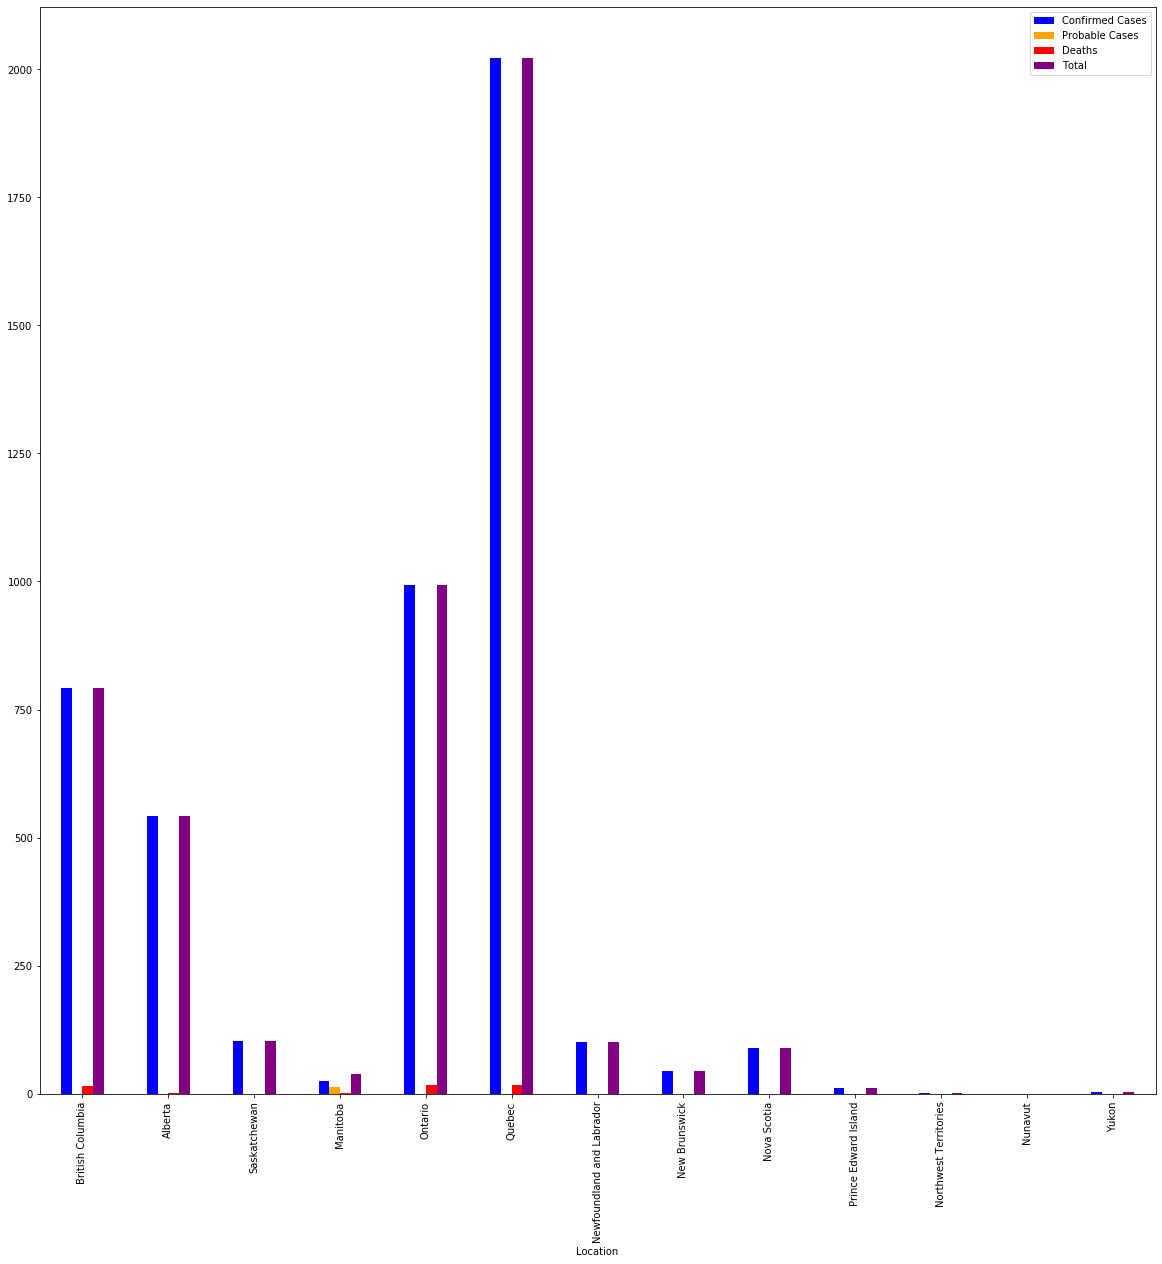

In [55]:
canadian_data.plot(kind = 'bar', y = ['Confirmed Cases', 'Probable Cases', 'Deaths', 'Total'], color = ['blue', 'orange', 'red', 'purple'], figsize = (20,20))
plt.savefig('canadian_provinces_all.png', bbox_inches = 'tight')

In [56]:
canadian_data.sort_values(by = 'Confirmed Cases', ascending = False, inplace = True)

##### Plots

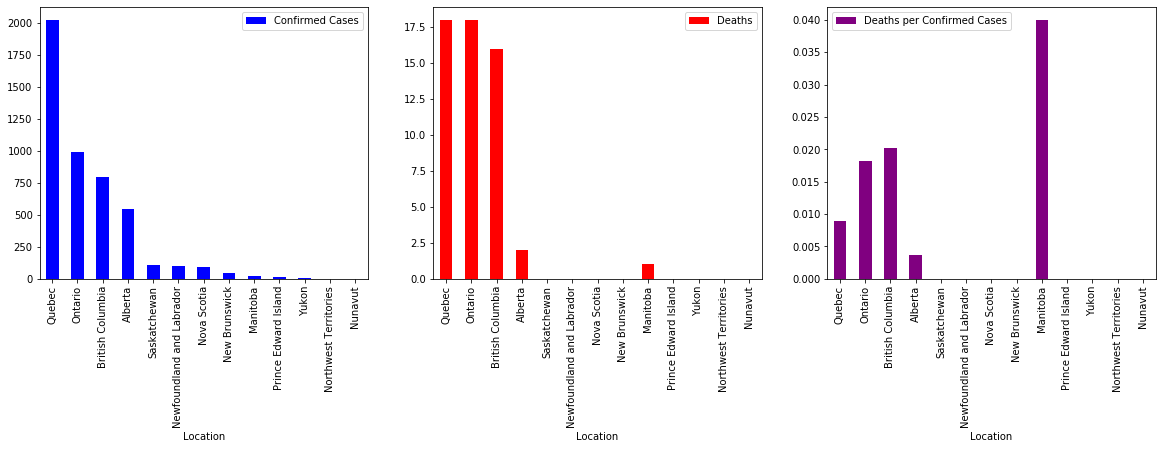

In [57]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
canadian_data.plot(kind = 'bar', y = 'Confirmed Cases', color = ['blue'], ax = ax1)
canadian_data.plot(kind = 'bar', y = 'Deaths', color = ['red'], ax = ax2)
canadian_data.plot(kind = 'bar', y = 'Deaths per Confirmed Cases', color = ['purple'], ax = ax3)
plt.savefig('canadian_provinces.png', bbox_inches = 'tight')

##### Tables

###### Total

In [58]:
canadian_data_total

,Confirmed Cases,Probable Cases,Deaths,Total,Today
Location,,,,,
Canada,4743,14,55,4757,NaN


###### Sorted by confirmed cases

In [59]:
canadian_data

,Confirmed Cases,Probable Cases,Deaths,Total,Today,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,
Quebec,2021,0,18,2021,NaN,0.008906,0.000237,2.108303e-06
Ontario,993,0,18,993,NaN,0.018127,0.000067,1.223505e-06
British Columbia,792,0,16,792,NaN,0.020202,0.000155,3.130554e-06
Alberta,542,0,2,542,NaN,0.003690,0.000123,4.531914e-07
Saskatchewan,104,0,0,104,NaN,0.000000,0.000088,0.000000e+00
Newfoundland and Labrador,102,0,0,102,NaN,0.000000,0.000196,0.000000e+00
Nova Scotia,90,0,0,90,NaN,0.000000,0.000092,0.000000e+00
New Brunswick,45,0,0,45,NaN,0.000000,0.000058,0.000000e+00
Manitoba,25,14,1,39,NaN,0.040000,0.000018,7.259439e-07


#### Per Capita

##### Plots

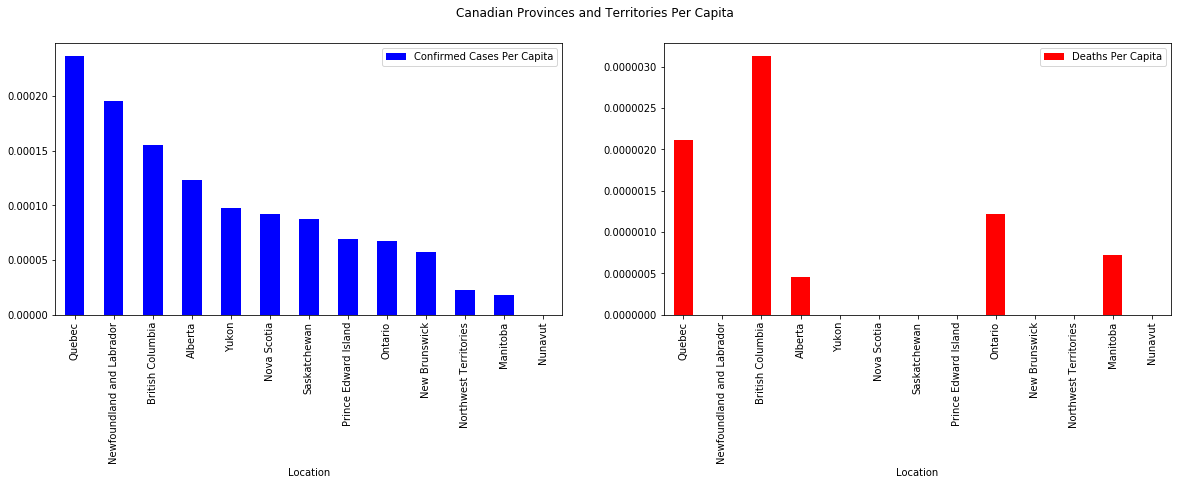

In [60]:
cdata_sorted = canadian_data.sort_values(by = 'Confirmed Cases Per Capita', ascending = False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Canadian Provinces and Territories Per Capita')

cdata_sorted.plot(kind = 'bar', y = 'Confirmed Cases Per Capita', color = ['blue'], ax = ax1)
cdata_sorted.plot(kind = 'bar', y = 'Deaths Per Capita', color = ['red'], ax = ax2)

plt.savefig('canadian_provinces_per_capita.png', bbox_inches = 'tight')

##### Tables

###### Sorted by confirmed cases per capita

In [61]:
cdata_sorted

,Confirmed Cases,Probable Cases,Deaths,Total,Today,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,
Quebec,2021,0,18,2021,NaN,0.008906,0.000237,2.108303e-06
Newfoundland and Labrador,102,0,0,102,NaN,0.000000,0.000196,0.000000e+00
British Columbia,792,0,16,792,NaN,0.020202,0.000155,3.130554e-06
Alberta,542,0,2,542,NaN,0.003690,0.000123,4.531914e-07
Yukon,4,0,0,4,NaN,0.000000,0.000097,0.000000e+00
Nova Scotia,90,0,0,90,NaN,0.000000,0.000092,0.000000e+00
Saskatchewan,104,0,0,104,NaN,0.000000,0.000088,0.000000e+00
Prince Edward Island,11,0,0,11,NaN,0.000000,0.000070,0.000000e+00
Ontario,993,0,18,993,NaN,0.018127,0.000067,1.223505e-06


###### Population

In [62]:
canadian_population

,Population
Location,
Ontario,14711827
Quebec,8537674
British Columbia,5110917
Alberta,4413146
Manitoba,1377517
Saskatchewan,1181666
Nova Scotia,977457
New Brunswick,779993
Newfoundland and Labrador,521365


## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL
3. Canadian data: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
4. Canadian population: https://en.wikipedia.org/wiki/List_of_Canadian_provinces_and_territories_by_population